In [ ]:
import perceval as pcvl
from perceval.algorithm import Sampler
from math import pi
from perceval.components import BS, PS
import numpy as np

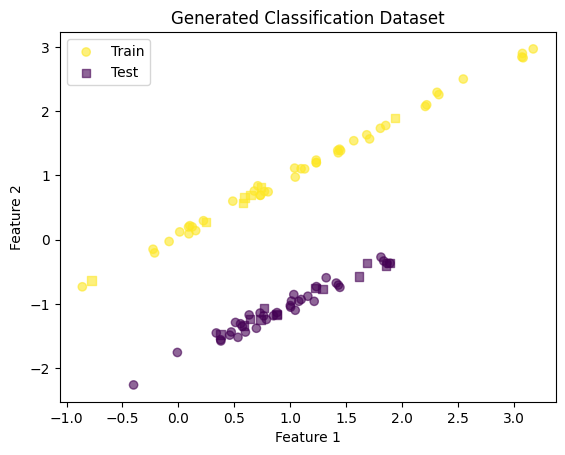

In [53]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate dataset with 2 features
X, y = make_classification(n_samples=100, n_features=2, n_classes=2, n_clusters_per_class=1, n_redundant = 0,random_state=42)

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label="Train", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='s', label="Test", alpha=0.6)
plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Generated Classification Dataset")
plt.show()



In [ ]:
CNOT = pcvl.catalog["postprocessed cnot"].build_circuit()
def phaseGate(param):
    return pcvl.Circuit(2).add(1, PS(param))
theta = [pcvl.P(f"theta{i}") for i in range(6)]
x = [pcvl.P(f"x{i}") for i in range(3)]

feature_map = pcvl.Circuit(4)
ansatz = pcvl.Circuit(4)

depth = 2

for i in range(2*depth + 1):
    if i % 2 == 0:
        ansatz.add(0, BS.Ry(theta = theta[i]))
        ansatz.add(2, BS.Ry(theta = theta[i + 1])) 
    else:
        ansatz.add(0,CNOT)

feature_map.add(0, BS.H())
feature_map.add(2, BS.H())
feature_map.add(0, phaseGate(x[0]))
feature_map.add(2, phaseGate(x[1]))
feature_map.add(0, CNOT)
feature_map.add(2, phaseGate(x[2]))
feature_map.add(0, CNOT)

vqc = pcvl.Processor(pcvl.SLOSBackend(), 4)
vqc.add(0, feature_map)
vqc.add(0, ansatz)

state_00 = pcvl.BasicState([1, 0, 1, 0, 1, 1])
state_01 = pcvl.BasicState([1, 0, 0, 1, 1, 1])
state_10 = pcvl.BasicState([0, 1, 1, 0, 1, 1])
state_11 = pcvl.BasicState([0, 1, 0, 1, 1, 1])

backend = pcvl.SLOSBackend()
vqc_params = vqc.get_parameters()

def get_probs(data):
    vqc_params[0].set_value(2*data[0])
    vqc_params[1].set_value(2*data[1])
    vqc_params[2].set_value(2*(pi - data[0])*(pi - data[1]))

    results = sampler.probs()['results']
    init_params = np.random.default_rng(42).random(size = (6))
    return results[state_10] + results[state_11]

def loss(params, data = X_train, target = y_train):
    pred_arr = np.zeros(shape = (data.shape[0]))
    for i in range(len(params)):
        vqc_params[f'theta{i}'].set_value(params[i])
    for i in range(data.shape[0]):
        pred_arr[i] = get_probs(data[i])
    
    loss = -np.mean(target*np.log2(pred_arr) + (1 - target)*np.log2(1 - pred_arr))
    print(loss)
    return loss


AssertionError: Port range exceeds circuit size (received (0, 1, 2, 3, 4, 5) but maximum expected value is 3)

In [ ]:
from scipy.optimize import minimize, OptimizeResult

init_params = np.random.default_rng(42).random(size = (6))

def callback(intermediate_result: OptimizeResult):
    print(intermediate_result.fun)

res = minimize(loss, init_params, args = (X_train, y_train), method = "L-BFGS-B", callback = callback)

In [ ]:
# Function to calculate accuracy
def calculate_accuracy(params, x_data, y_true):
    # Get predictions using the trained model
    predictions = np.zeros(shape = (x_data.shape[0]))
    for i in range(len(params)):
        vqc_params[f'theta{i}'].set_value(params[i])
    for i in range(x_data.shape[0]):
        predictions[i] = get_probs(x_data[i])
    predicted_labels = (predictions >= 0.5).astype(int)
    print(predictions)
    print(predicted_labels)
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == y_true)
    return accuracy
opt_params = res.x
# Calculate training accuracy
train_accuracy = calculate_accuracy(opt_params, X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = calculate_accuracy(opt_params, X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(y_test)


In [ ]:
other_ansatz = pcvl.Circuit(4)
other_FM = pcvl.Circuit(4)
other_depth = 10
x1 = pcvl.P(f"x{0}")
x2 = pcvl.P(f"x{1}")
x3 = pcvl.P(f"x{2}")

for i in range(4):
    other_ansatz.add(0, pcvl.Circuit(2) // (0, PS(x1)) // (0, BS()) // (0, PS(x1)) // (0, BS()))
    other_ansatz.add(2, pcvl.Circuit(2) // (0, PS(x2)) // (0, BS()) // (0, PS(x2)) // (0, BS()))
    other_ansatz.add(1, pcvl.Circuit(2) // (0, PS(x3)) // (0, BS()) // (0, PS(x3)) // (0, BS()))

for i in range(other_depth):
    p1 = pcvl.P(f"p{3*i}")
    p2 = pcvl.P(f"p{3*i + 1}")
    p3 = pcvl.P(f"p{3*i + 2}")

    t1 = pcvl.P(f"t{3*i}")
    t2 = pcvl.P(f"t{3*i + 1}")
    t3 = pcvl.P(f"t{3*i + 2}")
    other_ansatz.add(0, pcvl.Circuit(2) // (0, PS(p1)) // (0, BS()) // (0, PS(t1)) // (0, BS()))
    other_ansatz.add(2, pcvl.Circuit(2) // (0, PS(p2)) // (0, BS()) // (0, PS(t2)) // (0, BS()))
    other_ansatz.add(1, pcvl.Circuit(2) // (0, PS(p3)) // (0, BS()) // (0, PS(t3)) // (0, BS()))
pcvl.pdisplay(other_ansatz)

In [37]:
backend = pcvl.SLOSBackend()
vqc1 = pcvl.Circuit(4)
vqc1.add(0,other_FM)
vqc1.add(0,other_ansatz)


vqc1_params = vqc1.get_parameters()

print(vqc1_params)
def get_probs1(data):
    vqc1_params[0].set_value(data[0])
    vqc1_params[1].set_value(data[1])
    vqc1_params[2].set_value((pi - data[0])*(pi - data[1]))
    backend.set_circuit(vqc1)
    results = backend.all_prob(pcvl.BasicState([1,0,0,0]))
    out = results[0] + results[1]
    return out

def loss1(params, data = X_train, target = y_train):
    pred_arr = np.zeros(shape = (data.shape[0]))
    for i in range(len(params)//2):
        vqc1_params[3+2*i].set_value(params[i])
    for i in range(len(params)//2):
        vqc1_params[4+2*i].set_value(params[i + len(params)//2])
    for i in range(data.shape[0]):
        pred_arr[i] = get_probs1(data[i])
    
    loss = -np.mean(target*np.log2(pred_arr) + (1 - target)*np.log2(1 - pred_arr))
    return loss

[Parameter(name='x0', value=1.2339066795459237, min_v=0.0, max_v=6.283185307179586), Parameter(name='x1', value=1.1968407014240383, min_v=0.0, max_v=6.283185307179586), Parameter(name='x2', value=3.7099760221410447, min_v=0.0, max_v=6.283185307179586), Parameter(name='p0', value=0.15105079846291825, min_v=0.0, max_v=6.283185307179586), Parameter(name='t0', value=0.8967708137819317, min_v=0.0, max_v=6.283185307179586), Parameter(name='p1', value=0.02757849372274146, min_v=0.0, max_v=6.283185307179586), Parameter(name='t1', value=0.8498254836910816, min_v=0.0, max_v=6.283185307179586), Parameter(name='p2', value=0.3007498969474258, min_v=0.0, max_v=6.283185307179586), Parameter(name='t2', value=0.002297066963486971, min_v=0.0, max_v=6.283185307179586), Parameter(name='p3', value=0.35868461610867575, min_v=0.0, max_v=6.283185307179586), Parameter(name='t3', value=0.6564483161577194, min_v=0.0, max_v=6.283185307179586), Parameter(name='p4', value=0.03242729662527022, min_v=0.0, max_v=6.283

In [ ]:
from scipy.optimize import minimize, OptimizeResult

init_params = np.random.default_rng().random(size = (other_depth * 6))
arr = []
def callback(intermediate_result: OptimizeResult):
    print(intermediate_result.fun)
    arr.append(intermediate_result.fun)

res = minimize(loss1, init_params, args = (X_train, y_train), method = "L-BFGS-B", callback = callback)

0.7129799317092506
0.5928331185583626
0.5541487949604781
0.5353452904354964
0.5289743469987127
0.5239656672058122
0.523611917483952
0.5235977779531761
0.5235953793513458
0.5235952351807643
0.5235951505286032


In [65]:
b2 = pcvl.SLOSBackend()
b2.set_circuit(pcvl.Circuit(6))
np.where(b2.all_prob(pcvl.BasicState([0, 1, 0, 1, 1, 1])))

(array([85], dtype=int64),)

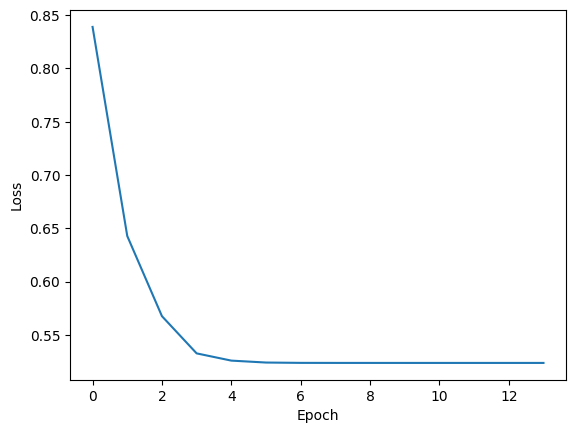

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.plot(arr, linestyle='-')

# Labeling axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plot
plt.show()

In [21]:
# Function to calculate accuracy
def calculate_accuracy(params, x_data, y_true):
    # Get predictions using the trained model
    predictions = np.zeros(shape = (x_data.shape[0]))
    for i in range(len(params)//2):
        vqc1_params[f't{i}'].set_value(params[i])
    for i in range(len(params)//2):
        vqc1_params[f'p{i}'].set_value(params[i + len(params)//2])
    for i in range(x_data.shape[0]):
        predictions[i] = get_probs1(x_data[i])
    predicted_labels = (predictions >= 0.5).astype(int)
    # Calculate accuracy
    accuracy = np.mean(predicted_labels == y_true)
    return accuracy

opt_params = res.x
# Calculate training accuracy
train_accuracy = calculate_accuracy(opt_params, X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
test_accuracy = calculate_accuracy(opt_params, X_test, y_test)
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8875
Testing Accuracy: 0.7500
